# EDA Project: King County Housing Data
### Markus Baden
Stakeholder: **Amy Williams**
* Seller and buyer
* Italian mafiosi
* sells several central houses(top10%) over time
* needs average outskirt houses over time to hide from the FBI

### Data import

In [84]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import geopy.distance

In [3]:
# from matplotlib.ticker import PercentFormatter
# plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
# plt.rcParams["figure.facecolor"]= "w"
# pd.plotting.register_matplotlib_converters()
# pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
#read the database string from the .env
load_dotenv()
DB_STRING = os.getenv('DB_STRING')

db = create_engine(DB_STRING)

# join house_details with house_sales and import to dataframe
query_string = ("SELECT * " + 
                "FROM eda.king_county_house_sales s " + 
                "INNER JOIN eda.king_county_house_details d " + 
                "ON s.house_id = d.id")
df_housing = pd.read_sql(query_string, db)

### 

In [5]:
# export the data to a csv-file as a backup
# df_housing.to_csv('data/housing.csv',index=False)

In [6]:
# import the data from a csv-file alternatively
# df_import = pd.read_csv('data/housing.csv')

### Data cleaning

In [7]:
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   house_id       21597 non-null  int64  
 3   id             21597 non-null  int64  
 4   id             21597 non-null  int64  
 5   bedrooms       21597 non-null  float64
 6   bathrooms      21597 non-null  float64
 7   sqft_living    21597 non-null  float64
 8   sqft_lot       21597 non-null  float64
 9   floors         21597 non-null  float64
 10  waterfront     19206 non-null  float64
 11  view           21534 non-null  float64
 12  condition      21597 non-null  int64  
 13  grade          21597 non-null  int64  
 14  sqft_above     21597 non-null  float64
 15  sqft_basement  21145 non-null  float64
 16  yr_built       21597 non-null  int64  
 17  yr_renovated   17749 non-null  float64
 18  zipcod

In [8]:
# drop unnecessary id column
df_housing.drop('id', axis=1, inplace=True)
df_housing.head()

,date,price,house_id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2014-10-13,221900.0,7129300520,3.0,1.00,1180.0,5650.0,1.0,NaN,0.0,...,7,1180.0,0.0,1955,0.0,98178,47.5112,-122.257,1340.0,5650.0
1,2014-12-09,538000.0,6414100192,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,...,7,2170.0,400.0,1951,19910.0,98125,47.7210,-122.319,1690.0,7639.0
2,2015-02-25,180000.0,5631500400,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,...,6,770.0,0.0,1933,NaN,98028,47.7379,-122.233,2720.0,8062.0
3,2014-12-09,604000.0,2487200875,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,...,7,1050.0,910.0,1965,0.0,98136,47.5208,-122.393,1360.0,5000.0
4,2015-02-18,510000.0,1954400510,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,...,8,1680.0,0.0,1987,0.0,98074,47.6168,-122.045,1800.0,7503.0


In [9]:
df_housing.view.unique()

array([ 0., nan,  3.,  4.,  2.,  1.])

In [10]:
df_housing.waterfront.unique()

array([nan,  0.,  1.])

In [11]:
df_housing.bathrooms.unique()

array([1.  , 2.25, 3.  , 2.  , 4.5 , 1.5 , 2.5 , 1.75, 2.75, 3.25, 4.  ,
       3.5 , 0.75, 4.75, 5.  , 4.25, 3.75, 1.25, 5.25, 6.  , 0.5 , 5.5 ,
       6.75, 5.75, 8.  , 7.5 , 7.75, 6.25, 6.5 ])

In [12]:
df_housing.dtypes

date              object
price            float64
house_id           int64
bedrooms         float64
bathrooms        float64
sqft_living      float64
sqft_lot         float64
floors           float64
waterfront       float64
view             float64
condition          int64
grade              int64
sqft_above       float64
sqft_basement    float64
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15    float64
sqft_lot15       float64
dtype: object

Assumptions for filling missing values with 0: 
* 'waterfront': houses at the waterfront would likely have data here, since it is an important selling point
* 'view': houses with a view better that 0 would also likely have data here, since it is an important selling point
* 'sqft_basement': houses with a basement would likely have data here, since it is an important selling point

In [13]:
# change date format from string to datetime
df_housing['date'] = pd.to_datetime(df_housing['date'], format='%Y/%m/%d')

# correct faulty year renovated values and fill NaNs with 0
df_housing['yr_renovated'] = df_housing.yr_renovated.apply(lambda x: (x/10))
df_housing.yr_renovated.fillna(0, inplace=True)

# fill NaN with 0 for 'waterfront', 'view' and 'sqft_basement' columns
df_housing.waterfront.fillna(0, inplace=True)
df_housing.view.fillna(0, inplace=True)
df_housing.sqft_basement.fillna(0, inplace=True)

In [14]:
# change data types of several columns to int
df_housing = df_housing.astype({'price': int, 
                                'bedrooms': int, 
                                'sqft_living': int, 
                                'sqft_lot': int, 
                                'waterfront': int, 
                                'view': int, 
                                'sqft_above':int, 
                                'sqft_basement': int, 
                                'yr_renovated': int,
                                'sqft_living15': int,
                                'sqft_lot15': int
                                })

In [15]:
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           21597 non-null  datetime64[ns]
 1   price          21597 non-null  int64         
 2   house_id       21597 non-null  int64         
 3   bedrooms       21597 non-null  int64         
 4   bathrooms      21597 non-null  float64       
 5   sqft_living    21597 non-null  int64         
 6   sqft_lot       21597 non-null  int64         
 7   floors         21597 non-null  float64       
 8   waterfront     21597 non-null  int64         
 9   view           21597 non-null  int64         
 10  condition      21597 non-null  int64         
 11  grade          21597 non-null  int64         
 12  sqft_above     21597 non-null  int64         
 13  sqft_basement  21597 non-null  int64         
 14  yr_built       21597 non-null  int64         
 15  yr_renovated   2159

In [16]:
df_housing.head()

,date,price,house_id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2014-10-13,221900,7129300520,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,2014-12-09,538000,6414100192,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,2015-02-25,180000,5631500400,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2014-12-09,604000,2487200875,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,2015-02-18,510000,1954400510,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Data is cleaned. There are no more missing values and the data types make sense.

### Houses in the outskirts and central houses

In [17]:
# mean coordinates of all houses
# group by houses because some might have been sold more than once
df_housing.groupby('house_id')

In [20]:
# median coordinates or city center as point of reference
median_coord = (df_housing.lat.median(), df_housing.long.median())
seattle_center = (47.608013, -122.335167)

# add distance from city center in miles to dataframe
df_housing['coords'] = list(zip(df_housing.lat, df_housing.long))
df_housing['distance'] = df_housing.coords.apply(lambda x: geopy.distance.geodesic(seattle_center, x).miles )

In [38]:
df_housing['usd_per_sqft'] = df_housing.price / df_housing.sqft_living
df_housing.head()

,date,price,house_id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,coords,distance,usd_per_sqft
0,2014-10-13,221900,7129300520,3,1.00,1180,5650,1.0,0,0,...,1955,0,98178,47.5112,-122.257,1340,5650,"(47.5112, -122.257)",7.622036,188.050847
1,2014-12-09,538000,6414100192,3,2.25,2570,7242,2.0,0,0,...,1951,1991,98125,47.7210,-122.319,1690,7639,"(47.721, -122.319)",7.842246,209.338521
2,2015-02-25,180000,5631500400,2,1.00,770,10000,1.0,0,0,...,1933,0,98028,47.7379,-122.233,2720,8062,"(47.7379, -122.233)",10.161211,233.766234
3,2014-12-09,604000,2487200875,4,3.00,1960,5000,1.0,0,0,...,1965,0,98136,47.5208,-122.393,1360,5000,"(47.5208, -122.393)",6.604160,308.163265
4,2015-02-18,510000,1954400510,3,2.00,1680,8080,1.0,0,0,...,1987,0,98074,47.6168,-122.045,1800,7503,"(47.6168, -122.045)",13.569108,303.571429


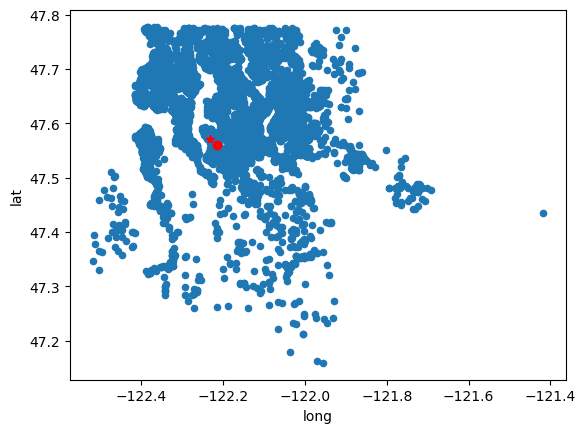

In [19]:
fig = df_housing.where(df_housing.price > 500000).plot(x='long', y='lat', kind='scatter')
plt.plot(df_housing.long.mean(), df_housing.lat.mean(), 'ro')
plt.plot(df_housing.long.median(), df_housing.lat.median(), 'r*')

In [21]:
df_housing.distance.describe()

count    21597.000000
mean        11.548859
std          6.676886
min          0.770659
25%          6.074611
50%         10.342017
75%         15.842257
max         48.163616
Name: distance, dtype: float64

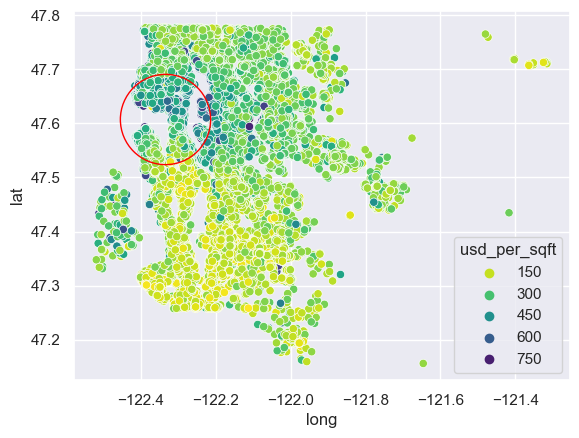

In [43]:
a = sns.scatterplot(data=df_housing.where(df_housing.grade >= 0), x='long', y='lat', hue='usd_per_sqft', palette="viridis_r")
a.plot([seattle_center[1]],[seattle_center[0]],'o',ms=65,mec='r',mfc='none')

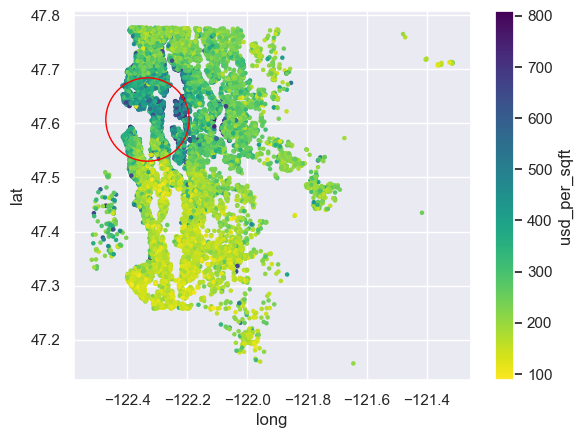

In [144]:
fig = df_housing.where(df_housing.grade >= 0).plot(x='long', y='lat', kind='scatter', c='usd_per_sqft', colormap='viridis_r', marker='.')
fig.plot([seattle_center[1]],[seattle_center[0]],'o',ms=60,mec='r',mfc='none')

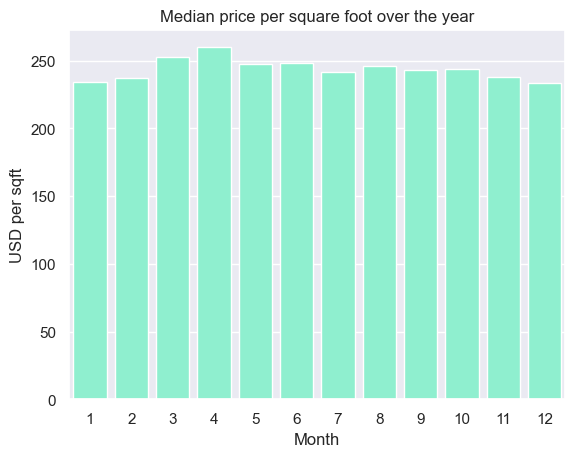

In [140]:
# plot median prices per sqft for each month
price_by_month = df_housing.groupby(df_housing.date.dt.month)['usd_per_sqft'].median()
price_by_month = pd.DataFrame({'month':price_by_month.index, 'median_usd_per_sqft':price_by_month.values})

fig = sns.barplot(data=price_by_month, x='month', y='median_usd_per_sqft', color='aquamarine')
fig.set(xlabel='Month', ylabel='USD per sqft', title='Median price per square foot over the year')
plt.show()

**Recommendations:**
* buy in winter
* sell in spring

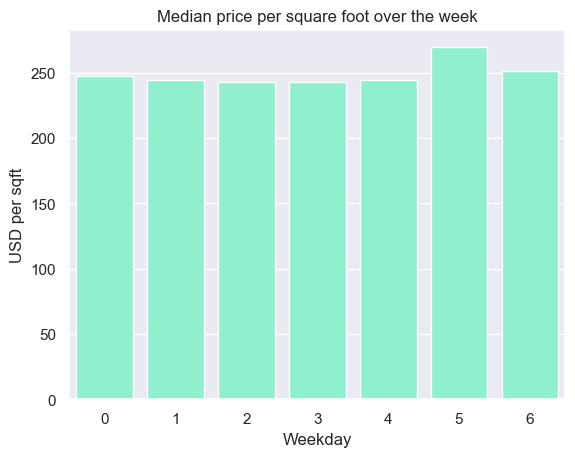

In [141]:
# plot median prices per sqft for each weekday
price_by_weekday = df_housing.groupby(df_housing.date.dt.weekday)['usd_per_sqft'].median()
price_by_weekday = pd.DataFrame({'weekday':price_by_weekday.index, 'median_usd_per_sqft':price_by_weekday.values})

fig = sns.barplot(data=price_by_weekday, x='weekday', y='median_usd_per_sqft', color='aquamarine')
fig.set(xlabel='Weekday', ylabel='USD per sqft', title='Median price per square foot over the week')
plt.show()

**Recommendations:**
* buy during the week
* sell on saturdays

### other ideas

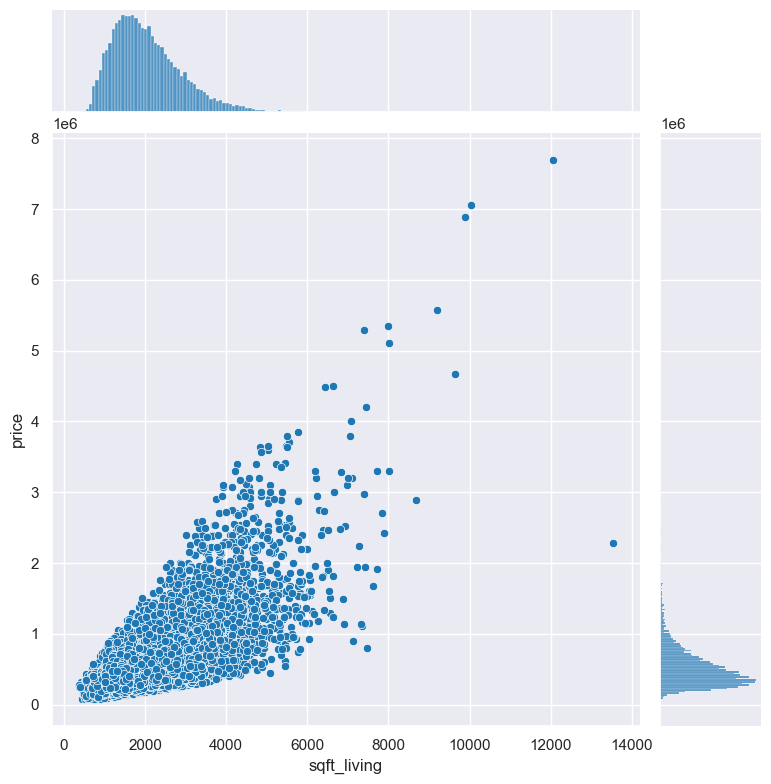

In [24]:
sns.set_theme(context='notebook', style='darkgrid', palette='tab10')
sns.color_palette("rocket", as_cmap=True)
jp = sns.jointplot(data=df_housing, x='sqft_living', y='price', height=8)#, hue='floors', xlim={0,6000}, ylim={0,4e6})
#jp.plot_joint(sns.kdeplot, color="r", zorder=1, levels=5)

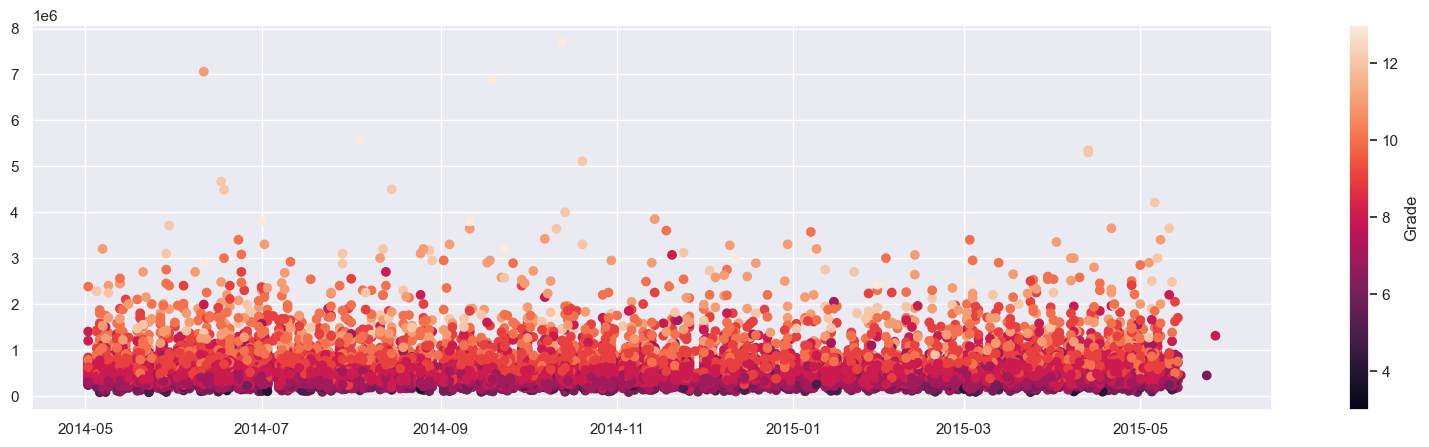

In [25]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.scatter(x=df_housing.date, y=df_housing.price, c=df_housing.grade, label = 'House sale prices')
plt.colorbar(label = "Grade")